## Implementing centrality measures over Neo4j

Import modules

In [2]:
import neo4j
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import EoN
import random as rd
import retworkx as rx

Connect to a database

In [2]:
# URI examples: "neo4j://localhost", "neo4j+s://xxx.databases.neo4j.io"
URI = "neo4j+s://183709dc.databases.neo4j.io"
AUTH = ("neo4j", "Q-93AoSmy3g0764NHYl4f_24MHcN3dtcakUnDvee9GU")

with neo4j.GraphDatabase.driver(URI, auth=AUTH) as driver:
    driver.verify_connectivity()


Query the adjacency matrix

In [3]:


def getting_ids(tx):
    result = tx.run("MATCH(n) RETURN ID(n)")
    result = list(result)
    l_ids=[]
    for i in result:
        l_ids.append(i[0])
    return np.array(l_ids)


def check_edge_existence(tx,id1,id2):
    result = tx.run("MATCH(n1)-[s]->(n2) WHERE ID(n1)={} AND ID(n2)={} RETURN count(s)".format(id1,id2))
    result = list(result)[0][0]
    return result

def getting_adj_matrix(db):
    # getting all nodes ids
    with driver.session(database=db) as session:
        ids = session.execute_read(getting_ids)
    N = len(ids)
    adj_mat = np.zeros((N,N))
    
    for i in tqdm(range(N)):
        for j in range(i,N):
            with driver.session(database=db) as session:
                n = session.execute_read(check_edge_existence,ids[i],ids[j])
            adj_mat[i,j] = n

    i_lower = np.tril_indices(N, -1)
    adj_mat[i_lower] = adj_mat.T[i_lower]
    return adj_mat



## Centrality

In [3]:
def eigen_centrality(A, eps=0.1, itemax=100):

    b_k = np.random.rand(A.shape[0])

    b_k1_norm = np.linalg.norm(b_k)
    v=0
    ite=0
    while abs(v-b_k1_norm)>eps and ite<itemax:
        v = b_k1_norm

        # calculate the matrix-by-vector product Ab
        b_k1 = A.dot(b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1,ord=2)

        # re normalize the vector
        b_k = 1/(b_k1_norm+0.001)*b_k1

        ite+=1

    return b_k

def deg_centrality(A):
    return A.dot(np.ones(len(A)))

def neuman_metric(A):
    N = len(A)
    M = np.linalg.inv(np.eye(N)-A)
    return np.diagonal(M)

def estrada_index(A):
    M = np.exp(A)
    return np.diagonal(M)




## Test

In [ ]:
A = getting_adj_matrix("neo4j")

Save the adjacency matrix

In [ ]:
np.save('adjacency_matrix_facebook.npy',A)

In [4]:
A  = np.load('adjacency_matrix_facebook.npy')

C:\Users\maxim\AppData\Local\Temp\ipykernel_19420\1123530179.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(eig_centrality, hist = True, kde = True,
c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2517: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


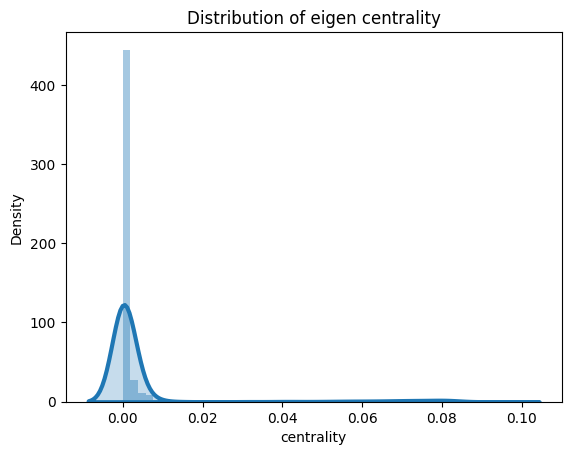

In [10]:
eig_centrality = eigen_centrality(A)


np.unique(eig_centrality, return_counts=True)
sns.distplot(eig_centrality, hist = True, kde = True,
                kde_kws = {'shade': True, 'linewidth': 3})
plt.title('Distribution of eigen centrality')
plt.xlabel('centrality')
plt.ylabel('Density')
plt.show()  

C:\Users\maxim\AppData\Local\Temp\ipykernel_19420\3855088887.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(deg_centrality, hist = True, kde = True,
c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2517: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


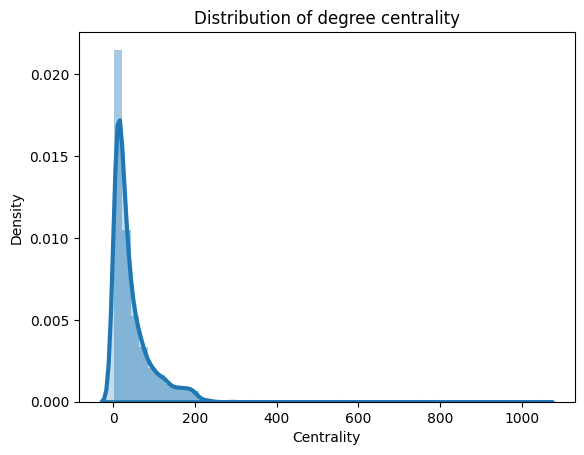

In [11]:
deg_centrality = deg_centrality(A)


np.unique(deg_centrality, return_counts=True)
sns.distplot(deg_centrality, hist = True, kde = True,
                kde_kws = {'shade': True, 'linewidth': 3})
plt.title('Distribution of degree centrality')
plt.xlabel('Centrality')
plt.ylabel('Density')
plt.show()  

C:\Users\maxim\AppData\Local\Temp\ipykernel_19420\2190714464.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(neuman_centrality, hist = True, kde = True,
c:\Users\maxim\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2517: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


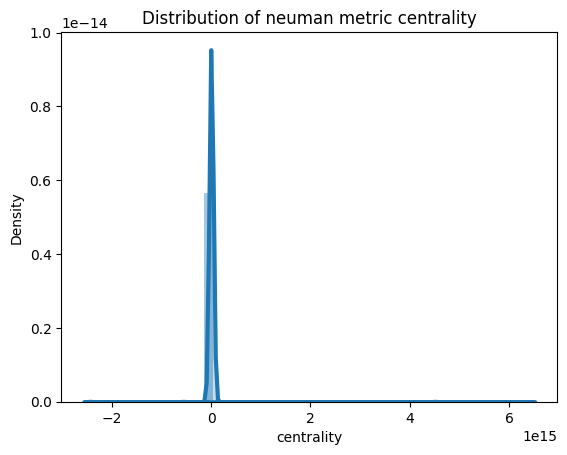

In [12]:
neuman_centrality = neuman_metric(A)


np.unique(neuman_centrality, return_counts=True)
sns.distplot(neuman_centrality, hist = True, kde = True,
                kde_kws = {'shade': True, 'linewidth': 3})
plt.title('Distribution of neuman metric centrality')
plt.xlabel('centrality')
plt.ylabel('Density')
plt.show()  

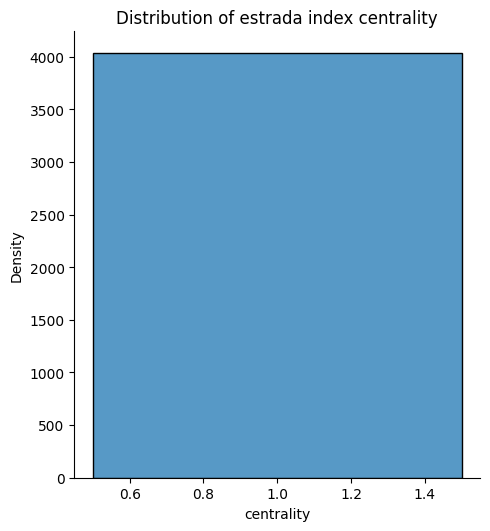

In [19]:
centrality_sequ = estrada_index(A)


np.unique(centrality_sequ, return_counts=True)
sns.displot(centrality_sequ)
plt.title('Distribution of estrada index centrality')
plt.xlabel('centrality')
plt.ylabel('Density')
plt.show()  

## Go further

In [5]:
## Create the graph

G = nx.from_numpy_array(A)
N = G.number_of_nodes()



## compute betweenness centrality tahnks to NetworkX library
G_r = rx.networkx_converter(G)
betw_centrality = rx.betweenness_centrality(G_r)

In [7]:
## Select some nodes thanks to complex algorithm

psi = 0.3   #proportion of node vaccinated
M = int(N*psi)   #Number of vaccinated node

from source.GA import GA
from source.netshield import netshield_plus

ga_selection,l_n,l_vuln = GA(G,M,N,n_gene=500,verbose =0, f_eps=0.0008, mut_r=1.3)
netshield_selection = netshield_plus(G,M,10) 


In [16]:
from source.netshield import netshield
netshield_selection2 = netshield(G_r,M) 

## Application 

C:\Users\maxim\AppData\Local\Temp\ipykernel_1752\4213064593.py:10: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = rd.sample(G.nodes,n_inf)


total infected: 3613


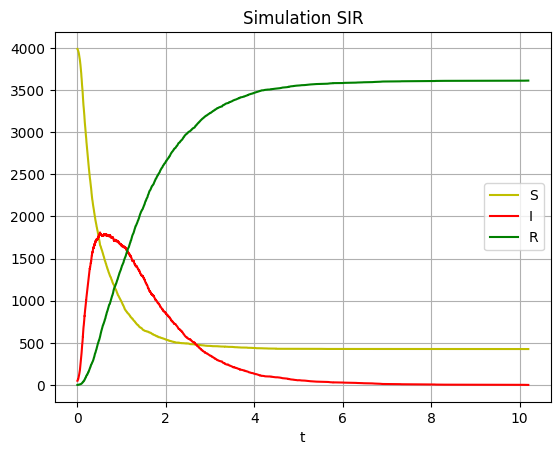

In [6]:
## Parameter setting 

n_inf = 50   # initial number of infected nodes

gamma = 1
tau = 0.3

## Simulation

infected = rd.sample(G.nodes,n_inf)

t, S, I, R = EoN.fast_SIR(G, tau, gamma,
                            initial_infecteds = infected)


## Plotting 

plt.figure(2)
plt.plot(t,S,'y',label='S')
plt.plot(t,I,'r',label='I')
plt.plot(t,R,'g',label='R')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.title('Simulation SIR')

print("total infected: {}".format(R[-1]))



with random vaccination

total infected: 2392


C:\Users\maxim\AppData\Local\Temp\ipykernel_1752\2743514008.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  vaccinated = rd.sample(G_i.nodes,M)
C:\Users\maxim\AppData\Local\Temp\ipykernel_1752\2743514008.py:15: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = rd.sample(G_i.nodes,n_inf)


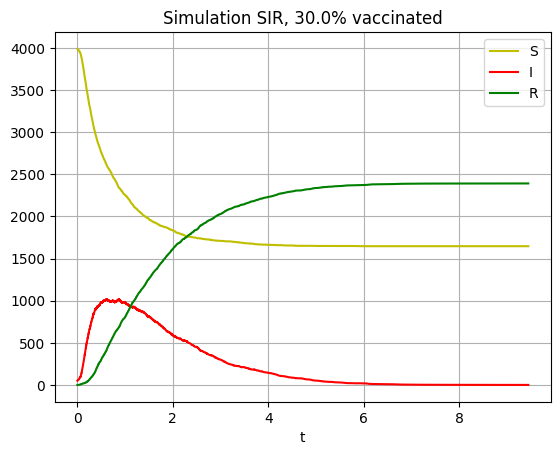

In [8]:
## Vaccination

psi = 0.3   #proportion of node vaccinated
M = int(N*psi)   #Number of vaccinated node

G_i = G.copy()

vaccinated = rd.sample(G_i.nodes,M)

G_i.remove_nodes_from(vaccinated)


## Simulation

infected = rd.sample(G_i.nodes,n_inf)

t, S, I, R = EoN.fast_SIR(G_i, tau, gamma,
                            initial_infecteds = infected)


## Plotting 

plt.figure(2)
plt.plot(t,S+M,'y',label='S')
plt.plot(t,I,'r',label='I')
plt.plot(t,R,'g',label='R')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.title('Simulation SIR, '+str(psi*100)+'% vaccinated')

print("total infected: {}".format(R[-1]))


with eigen centrality vaccination

total infected: 2283


C:\Users\maxim\AppData\Local\Temp\ipykernel_19420\1585760831.py:16: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = rd.sample(G_i.nodes,n_inf)


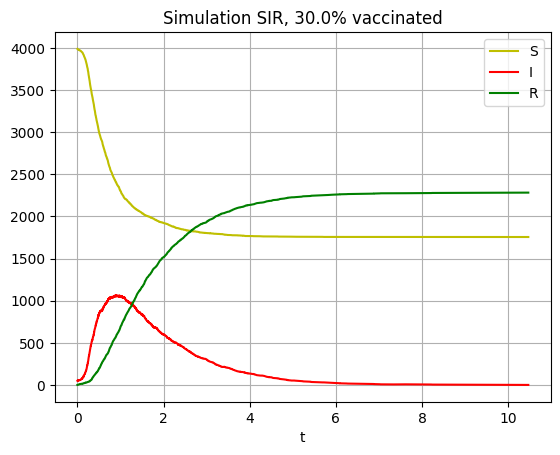

In [20]:
## Vaccination

psi = 0.3   #proportion of node vaccinated
M = int(N*psi)   #Number of vaccinated node

G_i = G.copy()

vaccinated = np.argsort(eig_centrality)[-M:]


G_i.remove_nodes_from(vaccinated)


## Simulation

infected = rd.sample(G_i.nodes,n_inf)

t, S, I, R = EoN.fast_SIR(G_i, tau, gamma,
                            initial_infecteds = infected)


## Plotting 

plt.figure(2)
plt.plot(t,S+M,'y',label='S')
plt.plot(t,I,'r',label='I')
plt.plot(t,R,'g',label='R')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.title('Simulation SIR, '+str(psi*100)+'% vaccinated')

print("total infected: {}".format(R[-1]))

vaccination with degree centrality

total infected: 1983


C:\Users\maxim\AppData\Local\Temp\ipykernel_19420\751333605.py:16: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = rd.sample(G_i.nodes,n_inf)


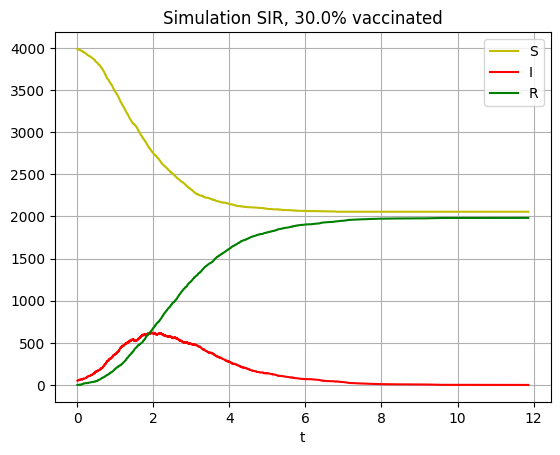

In [21]:
## Vaccination

psi = 0.3   #proportion of node vaccinated
M = int(N*psi)   #Number of vaccinated node

G_i = G.copy()

vaccinated = np.argsort(deg_centrality)[-M:]


G_i.remove_nodes_from(vaccinated)


## Simulation

infected = rd.sample(G_i.nodes,n_inf)

t, S, I, R = EoN.fast_SIR(G_i, tau, gamma,
                            initial_infecteds = infected)


## Plotting 

plt.figure(2)
plt.plot(t,S+M,'y',label='S')
plt.plot(t,I,'r',label='I')
plt.plot(t,R,'g',label='R')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.title('Simulation SIR, '+str(psi*100)+'% vaccinated')

print("total infected: {}".format(R[-1]))

vaccination with power centrality

C:\Users\maxim\AppData\Local\Temp\ipykernel_19420\2674326256.py:16: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = rd.sample(G_i.nodes,n_inf)


total infected: 2501


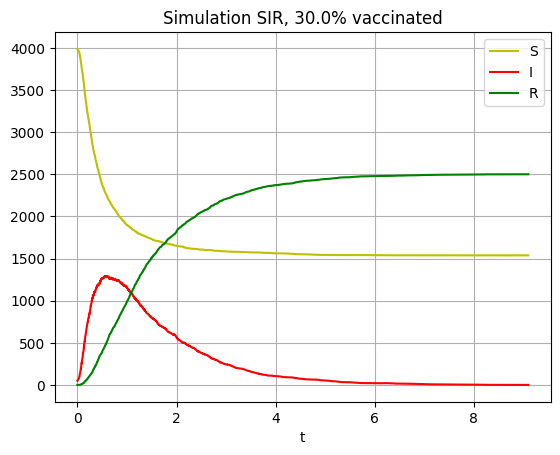

In [26]:
## Vaccination

psi = 0.3   #proportion of node vaccinated
M = int(N*psi)   #Number of vaccinated node

G_i = G.copy()

vaccinated = np.argsort(neuman_centrality)[-M:]


G_i.remove_nodes_from(vaccinated)


## Simulation

infected = rd.sample(G_i.nodes,n_inf)

t, S, I, R = EoN.fast_SIR(G_i, tau, gamma,
                            initial_infecteds = infected)


## Plotting 

plt.figure(2)
plt.plot(t,S+M,'y',label='S')
plt.plot(t,I,'r',label='I')
plt.plot(t,R,'g',label='R')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.title('Simulation SIR, '+str(psi*100)+'% vaccinated')

print("total infected: {}".format(R[-1]))

with betweenness centrality vaccination

total infected: 1636


C:\Users\maxim\AppData\Local\Temp\ipykernel_2144\1408463719.py:16: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = rd.sample(G_i.nodes,n_inf)


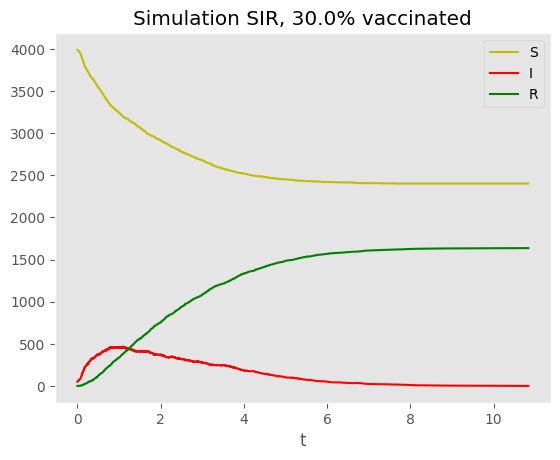

In [33]:
## Vaccination

psi = 0.3   #proportion of node vaccinated
M = int(N*psi)   #Number of vaccinated node

G_i = G.copy()

b_vaccinated = np.argsort(list(betw_centrality.values()))[-M:]


G_i.remove_nodes_from(b_vaccinated)


## Simulation

infected = rd.sample(G_i.nodes,n_inf)

t, S, I, R = EoN.fast_SIR(G_i, tau, gamma,
                            initial_infecteds = infected)


## Plotting 

plt.figure(5)
plt.plot(t,S+M,'y',label='S')
plt.plot(t,I,'r',label='I')
plt.plot(t,R,'g',label='R')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.title('Simulation SIR, '+str(psi*100)+'% vaccinated')

print("total infected: {}".format(R[-1]))

with genetic algorithm vaccination

total infected: 2292


C:\Users\maxim\AppData\Local\Temp\ipykernel_2144\1527148513.py:16: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = rd.sample(G_i.nodes,n_inf)


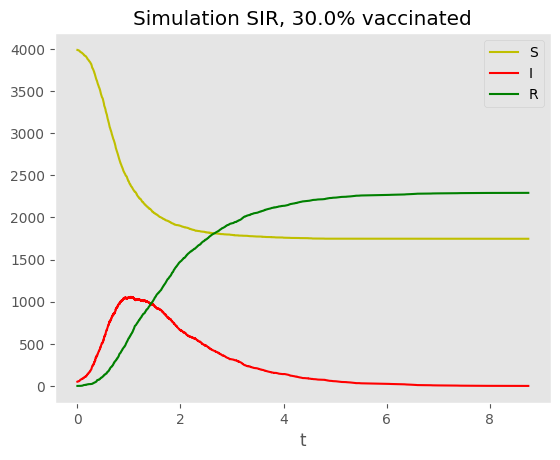

In [22]:
## Vaccination

psi = 0.3   #proportion of node vaccinated
M = int(N*psi)   #Number of vaccinated node

G_i = G.copy()

vaccinated = ga_selection


G_i.remove_nodes_from(vaccinated)


## Simulation

infected = rd.sample(G_i.nodes,n_inf)

t, S, I, R = EoN.fast_SIR(G_i, tau, gamma,
                            initial_infecteds = infected)


## Plotting 

plt.figure(2)
plt.plot(t,S+M,'y',label='S')
plt.plot(t,I,'r',label='I')
plt.plot(t,R,'g',label='R')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.title('Simulation SIR, '+str(psi*100)+'% vaccinated')

print("total infected: {}".format(R[-1]))

with netshield algorithm

total infected: 2240


C:\Users\maxim\AppData\Local\Temp\ipykernel_20100\2622230016.py:16: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  infected = rd.sample(G_i.nodes,n_inf)


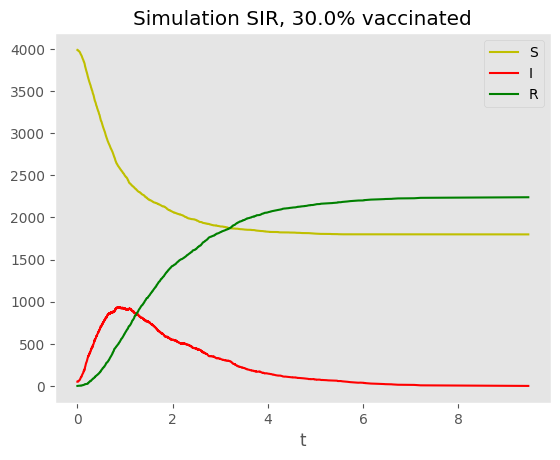

In [20]:
## Vaccination

psi = 0.3   #proportion of node vaccinated
M = int(N*psi)   #Number of vaccinated node

G_i = G.copy()

vaccinated = netshield_selection2


G_i.remove_nodes_from(vaccinated)


## Simulation

infected = rd.sample(G_i.nodes,n_inf)

t, S, I, R = EoN.fast_SIR(G_i, tau, gamma,
                            initial_infecteds = infected)


## Plotting 

plt.figure(7)
plt.plot(t,S+M,'y',label='S')
plt.plot(t,I,'r',label='I')
plt.plot(t,R,'g',label='R')
plt.legend()
plt.grid()
plt.xlabel('t')
plt.title('Simulation SIR, '+str(psi*100)+'% vaccinated')

print("total infected: {}".format(R[-1]))

## Delete nodes on Neo4j

delelete the nodes to protect the Neo4j database

In [ ]:

def delete_node(tx,id):
    tx.run("MATCH(n) WHERE ID(n)={} DETACH DELETE n".format(id))

def immunize_network(db,vaccinated):
    # getting all nodes ids
    with driver.session(database=db) as session:
        ids = session.execute_read(getting_ids)
    N = len(ids)
    with driver.session(database=db) as session:
        for node in vaccinated:
            id = node[ids]
            session.execute_read(delete_node,id)



In [ ]:
immunize_network('neo4j',b_vaccinated)

close the database

In [ ]:
with driver.session(database='neo4j') as session:
    session.close()
    driver.close()